In [1]:
import sys
print(sys.version)


3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]


In [3]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Asus\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [3]:
pip install --upgrade tensorflow


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Asus\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [28]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
print("Physical Devices: ", physical_devices)


Num GPUs Available:  0
Physical Devices:  []


In [ ]:
!pip uninstall tensorflow


In [3]:

# Install OpenCV
!pip install opencv-python

# Install NumPy
!pip install numpy

# Install Matplotlib
!pip install matplotlib


You should consider upgrading via the 'C:\Users\Asus\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\Asus\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\Asus\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [1]:
# Cell 1: Import libraries
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt


In [2]:
# Cell 2: Set up directories
BASE_DIR = 'facial_recognition_project'
PEOPLE_DIR = os.path.join(BASE_DIR, 'people')
MODEL_DIR = os.path.join(BASE_DIR, 'model')
os.makedirs(PEOPLE_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

In [3]:
# Cell 3: Data collection function
def collect_face_data(name, num_images):
    person_dir = os.path.join(PEOPLE_DIR, name)
    os.makedirs(person_dir, exist_ok=True)
    
    cap = cv2.VideoCapture(0)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    count = 0
    while count < num_images:
        ret, frame = cap.read()
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        
        for (x, y, w, h) in faces:
            cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
            face = frame[y:y+h, x:x+w]
            face = cv2.resize(face, (105, 105))
            cv2.imwrite(os.path.join(person_dir, f'{name}_{count}.jpg'), face)
            count += 1
            break
        
        cv2.imshow('Collecting Face Data', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def augment_image(img):
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )
    img = img.reshape((1,) + img.shape)  # Reshape for batch processing
    aug_iter = datagen.flow(img, batch_size=1)
    aug_img = next(aug_iter)[0]  # Generate one augmented image
    return aug_img

In [5]:
# Cell 4: Data preprocessing functions
def preprocess_image(image_path, augment=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (105, 105))
    img = img.astype(np.float32) / 255.0
    if augment:
        img = augment_image(img)
    return img

def create_pairs(directory):
    people = os.listdir(directory)
    pairs = []
    labels = []
    
    for person in people:
        person_dir = os.path.join(directory, person)
        person_images = [os.path.join(person_dir, f) for f in os.listdir(person_dir)]
        
        # Positive pairs
        for i in range(len(person_images)):
            for j in range(i+1, len(person_images)):
                pairs.append((person_images[i], person_images[j]))
                labels.append(1)
        
        # Negative pairs
        other_people = [p for p in people if p != person]
        for other_person in other_people:
            other_person_dir = os.path.join(directory, other_person)
            other_person_images = [os.path.join(other_person_dir, f) for f in os.listdir(other_person_dir)]
            for i in range(min(len(person_images), len(other_person_images))):
                pairs.append((person_images[i], other_person_images[i]))
                labels.append(0)
    
    return np.array(pairs), np.array(labels)

In [6]:
# Cell 5: Model formation functions
def create_base_network(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.Dropout(0.3)(x)  # Adding dropout to reduce overfitting
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(256, (3, 3), activation='relu')(x)  # Deepening the network
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    return Model(inputs, x)






In [7]:
import tensorflow as tf
@tf.keras.utils.register_keras_serializable()
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, tf.keras.backend.epsilon()))



In [8]:

def contrastive_loss(y_true, y_pred, margin=1):
    y_true = tf.cast(y_true, y_pred.dtype)
    square_pred = tf.math.square(y_pred)
    margin_square = tf.math.square(tf.math.maximum(margin - y_pred, 0))
    return tf.math.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)



In [9]:

def create_siamese_model(input_shape):
    base_network = create_base_network(input_shape)
    input_a = layers.Input(shape=input_shape)
    input_b = layers.Input(shape=input_shape)
    processed_a = base_network(input_a)
    processed_b = base_network(input_b)
    distance = layers.Lambda(euclidean_distance)([processed_a, processed_b])
    model = Model(inputs=[input_a, input_b], outputs=distance)
    return model

In [10]:
# Cell 6: Training function
def train_model(model, pairs, labels):
    images_a = []
    images_b = []
    for pair in pairs:
        images_a.append(preprocess_image(pair[0]))
        images_b.append(preprocess_image(pair[1]))
    
    images_a = np.array(images_a)
    images_b = np.array(images_b)
    
    # Compile the model with accuracy as a metric
    model.compile(loss=contrastive_loss, 
                  optimizer=optimizers.Adam(0.0001),
                  metrics=['accuracy'])  # Add accuracy metric
    
    # Train the model and return the history
    history = model.fit([images_a, images_b], labels, 
                        epochs=20, 
                        batch_size=16, 
                        validation_split=0.2)
    
    return history


In [11]:
# Cell 7: Face recognition function
def recognize_face(model, face_database, input_face, threshold=0.2):
    results = []
    
    if isinstance(input_face, str):
        # If input_face is a file path
        input_face = preprocess_image(input_face)
    
    input_face = np.expand_dims(input_face, axis=0)
    
    for name, known_face in face_database.items():
        known_face = np.expand_dims(known_face, axis=0)
        distance = model.predict([input_face, known_face])[0][0]
        if distance < threshold:
            results.append((name, distance))
    
    return sorted(results, key=lambda x: x[1])

In [12]:
# Cell 8: Real-time facial recognition function
def real_time_facial_recognition(model, face_database, threshold=0.2):
    cap = cv2.VideoCapture(0)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        for (x, y, w, h) in faces:
            face = frame[y:y+h, x:x+w]
            face = cv2.resize(face, (105, 105))
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = face.astype(np.float32) / 255.0
            results = recognize_face(model, face_database, face)
            if results:
                name, distance = results[0]
                if distance < threshold:
                    color = (0, 255, 0)  # Green
                    text = f"{name}: {distance:.2f}"
                else:
                    color = (0, 0, 255)  # Red
                    text = f"Unknown: {distance:.2f}"
            else:
                color = (0, 0, 255)  # Red
                text = "Unknown"
            cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
            cv2.putText(frame, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
        cv2.imshow('Real-time Facial Recognition', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [64]:
# Cell 9: Collect face data
person_name = input("Enter the name of the person: ")
num_images = int(input("Enter the number of images to collect: "))
collect_face_data(person_name, num_images)

Enter the name of the person:  Sanskar
Enter the number of images to collect:  100


In [13]:
# Cell 10: Create pairs and labels (when you want to train a new model)
pairs, labels = create_pairs(PEOPLE_DIR)
print(f"Created {len(pairs)} pairs for training")

Created 49605 pairs for training


In [14]:
import tensorflow as tf
tf.config.threading.set_intra_op_parallelism_threads(4)  # Set to the number of threads you want to use
tf.config.threading.set_inter_op_parallelism_threads(4)



Epoch 1/20
2481/2481 ━━━━━━━━━━━━━━━━━━━━ 1641s 660ms/step - accuracy: 0.3787 - loss: 1.5542 - val_accuracy: 0.5617 - val_loss: 0.8551
Epoch 2/20
2481/2481 ━━━━━━━━━━━━━━━━━━━━ 1605s 647ms/step - accuracy: 0.5746 - loss: 0.6352 - val_accuracy: 0.8708 - val_loss: 1.0553
Epoch 3/20
2481/2481 ━━━━━━━━━━━━━━━━━━━━ 1603s 646ms/step - accuracy: 0.6047 - loss: 0.6902 - val_accuracy: 0.7330 - val_loss: 0.9678
Epoch 4/20
2481/2481 ━━━━━━━━━━━━━━━━━━━━ 1603s 646ms/step - accuracy: 0.5726 - loss: 0.7273 - val_accuracy: 0.8167 - val_loss: 0.9606
Epoch 5/20
2481/2481 ━━━━━━━━━━━━━━━━━━━━ 1604s 646ms/step - accuracy: 0.5778 - loss: 0.6435 - val_accuracy: 0.8254 - val_loss: 1.1857
Epoch 6/20
2481/2481 ━━━━━━━━━━━━━━━━━━━━ 1604s 646ms/step - accuracy: 0.5448 - loss: 0.5897 - val_accuracy: 0.8619 - val_loss: 1.0505
Epoch 7/20
2481/2481 ━━━━━━━━━━━━━━━━━━━━ 1607s 648ms/step - accuracy: 0.5593 - loss: 0.6201 - val_accuracy: 0.8344 - val_loss: 0.9452
Epoch 8/20
2481/2481 ━━━━━━━━━━━━━━━━━━━━ 1609s 648ms/

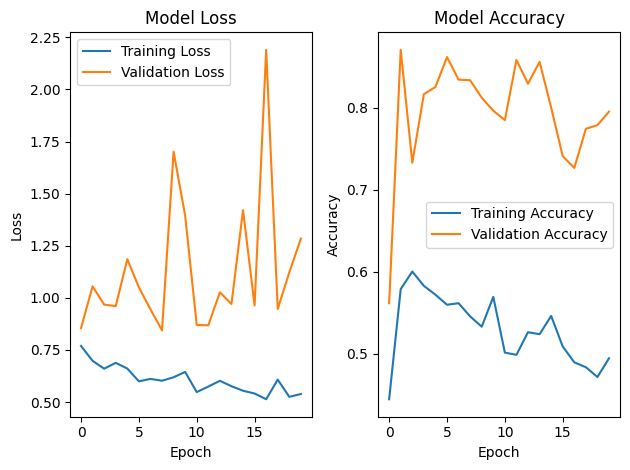

In [15]:
# Cell 11: Create and train the model (uncomment and run this cell when you want to train a new model)

input_shape = (105, 105, 3)
siamese_model = create_siamese_model(input_shape)
history = train_model(siamese_model, pairs, labels)

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
# Cell 12: Save the model (run this cell after training a new model)

model_save_path = os.path.join(MODEL_DIR, 'siamese_model.keras')
siamese_model.save(model_save_path)
print(f"Model saved to {model_save_path}")


NameError: name 'siamese_model' is not defined

In [13]:
# Cell 13: Load the saved model and create face database 
def load_model_and_database():
    model_path = os.path.join(MODEL_DIR, 'siamese_model.keras')
    siamese_model = load_model(model_path, custom_objects={'euclidean_distance': euclidean_distance}, compile=False)
    siamese_model.compile(loss=contrastive_loss, optimizer='adam')

    face_database = {}
    for person in os.listdir(PEOPLE_DIR):
        person_dir = os.path.join(PEOPLE_DIR, person)
        if os.path.isdir(person_dir):
            face_image_path = os.path.join(person_dir, os.listdir(person_dir)[0])
            face_database[person] = preprocess_image(face_image_path)
    
    return siamese_model, face_database

In [ ]:
# Cell 14: Run real-time facial recognition
siamese_model, face_database = load_model_and_database()
real_time_facial_recognition(siamese_model, face_database)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━

In [14]:
# Load the saved model
from tensorflow.keras.models import load_model

custom_objects = {
    'euclidean_distance': euclidean_distance
}
model_path = os.path.join(MODEL_DIR, 'siamese_model.keras')
siamese_model = load_model(model_path, custom_objects=custom_objects, compile=False)


In [15]:
siamese_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 105, 105, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_5 (InputLayer)    │ (None, 105, 105, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ functional_2 (Functional)     │ (None, 128)               │       2,205,824 │ input_layer_4[0][0],       │
│                               │                           │                 │ input_layer_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lambda_1 (Lambda)             │ (None, 1)                 │               0 │ functional_2[0][0],        │
│                               │                           │                 │ functional_2[1][0]         │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,205,824 (8.41 MB)

 Trainable params: 2,205,824 (8.41 MB)

 Non-trainable params: 0 (0.00 B)